In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Data

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/loc_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/loc_val.tfr'

# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        class_list.append(line)

In [4]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Training

In [5]:
IMG_SIZE = 224
N_CLASS = len(class_list)

N_EPOCHS = 50
N_BATCH = 40

learning_rate = 0.0001

N_TRAIN = 3000
N_VAL = 685
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [8]:
## train dataset
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [9]:
## validation dataset
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

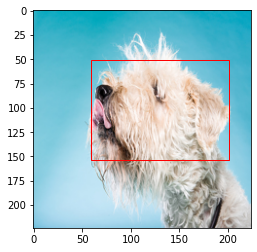

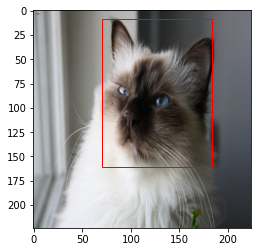

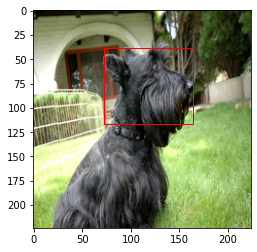

In [10]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    '''bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

## Vanilla CNN model로 Localization 학습하기¶

In [11]:
# Vanilla CNN model
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    return model

def loss_fn(y_true, y_pred):
    return keras.losses.MeanSquaredError()(y_true, y_pred)

In [12]:
model = create_model()

## learning rate scheduling
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(keras.optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [13]:
model.fit(train_dataset, 
          epochs=N_EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps)

Epoch 1/50
75/75 [==============================] - 45s 85ms/step - loss: 0.0241 - val_loss: 0.0233
Epoch 2/50
75/75 [==============================] - 7s 81ms/step - loss: 0.0221 - val_loss: 0.0206
Epoch 3/50
75/75 [==============================] - 8s 81ms/step - loss: 0.0198 - val_loss: 0.0192
Epoch 4/50
75/75 [==============================] - 8s 82ms/step - loss: 0.0180 - val_loss: 0.0193
Epoch 5/50
75/75 [==============================] - 8s 82ms/step - loss: 0.0161 - val_loss: 0.0168
Epoch 6/50
75/75 [==============================] - 8s 83ms/step - loss: 0.0147 - val_loss: 0.0181
Epoch 7/50
75/75 [==============================] - 8s 83ms/step - loss: 0.0134 - val_loss: 0.0159
Epoch 8/50
75/75 [==============================] - 8s 83ms/step - loss: 0.0121 - val_loss: 0.0154
Epoch 9/50
75/75 [==============================] - 8s 84ms/step - loss: 0.0109 - val_loss: 0.0170
Epoch 10/50
75/75 [==============================] - 8s 85ms/step - loss: 0.0099 - val_loss: 0.0149
Epoch 11

In [14]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), 
                          pred_rect_w, pred_rect_h,
                          fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# calculate IOU (Intersection Over Union)
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    
    for idx in range(N_BATCH):
        if (flag):
            if idx == res:
                flag = False
                break
            
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
            
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)

        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou / N_VAL

print(avg_iou)

0.5067522750577276
